In [1]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import model_from_json
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# load json and create model
json_file = open('model_daily_v1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_daily_v1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
loaded_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Loaded model from disk


In [3]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    print(type(ds))
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
import csv
time_step = []
temps = []

with open('./timeseries_daily.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps).astype("float64")
time = np.array(time_step).astype("float64")
time = time[2500:]
series = series[2500:]
time = time-2500
series[series>300] = 300

In [6]:
window_size = 100
batch_size = 52
shuffle_buffer_size = 1000

split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [7]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 256)         16640     
_________________________________________________________________
dense_1 (Dense)              (None, None, 128)         32896     
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           129       
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [8]:
rnn_forecast = model_forecast(loaded_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>


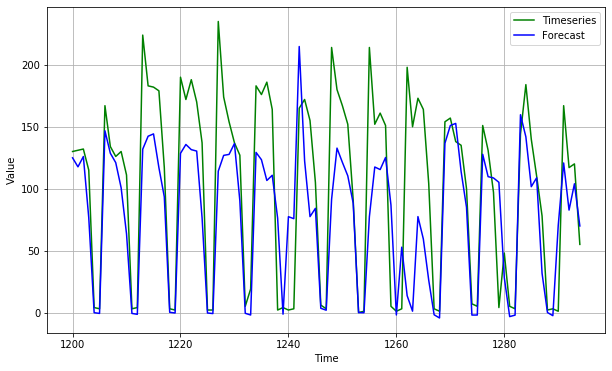

In [9]:
plt.figure(figsize=(10, 6))
start = 100
show_length = 150
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[start:start+show_length], rnn_forecast[start:show_length+start]-x_valid[start:start+show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

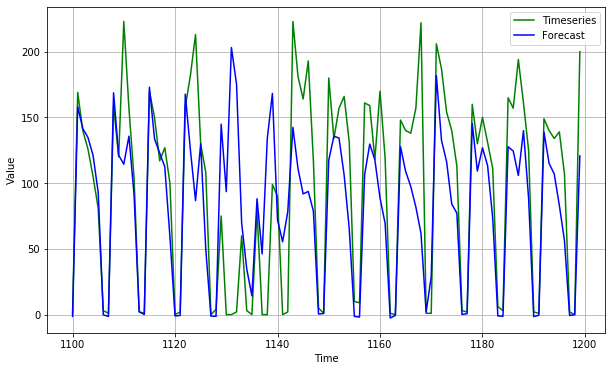

In [10]:
plt.figure(figsize=(10, 6))
start = 0
show_length = 100
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [14]:
import numpy as np
np.mean(np.sqrt(np.square(x_valid-rnn_forecast)))

36.15260342787474

In [11]:
predict_size=24*7
test = x_valid[0:predict_size]

In [12]:
for i in range(predict_size):
    test = test.reshape(1,predict_size,1)
    forecast = loaded_model.predict(test)
    test = np.concatenate([test[0][1:], np.array(forecast[0][-1]).reshape([1,1])], axis=0)

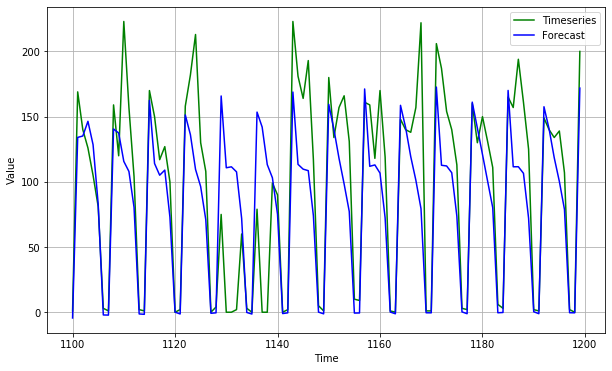

In [13]:
plt.figure(figsize=(10, 6))
start = 0
show_length = 100
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], test[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [11]:
import pandas as pd
date = pd.read_csv("date_daily.csv")
date = date[2500:]
date.drop("Unnamed: 0", inplace=True, axis=1)

In [13]:
date["Date"].iloc[-50:]

3745    2020-04-17
3746    2020-04-18
3747    2020-04-19
3748    2020-04-20
3749    2020-04-21
3750    2020-04-22
3751    2020-04-23
3752    2020-04-24
3753    2020-04-25
3754    2020-04-26
3755    2020-04-27
3756    2020-04-28
3757    2020-04-29
3758    2020-04-30
3759    2020-05-01
3760    2020-05-02
3761    2020-05-03
3762    2020-05-04
3763    2020-05-05
3764    2020-05-06
3765    2020-05-07
3766    2020-05-08
3767    2020-05-09
3768    2020-05-10
3769    2020-05-11
3770    2020-05-12
3771    2020-05-13
3772    2020-05-14
3773    2020-05-15
3774    2020-05-16
3775    2020-05-17
3776    2020-05-18
3777    2020-05-19
3778    2020-05-20
3779    2020-05-21
3780    2020-05-22
3781    2020-05-23
3782    2020-05-24
3783    2020-05-25
3784    2020-05-26
3785    2020-05-27
3786    2020-05-28
3787    2020-05-29
3788    2020-05-30
3789    2020-05-31
3790    2020-06-01
3791    2020-06-02
3792    2020-06-03
3793    2020-06-04
3794    2020-06-05
Name: Date, dtype: object

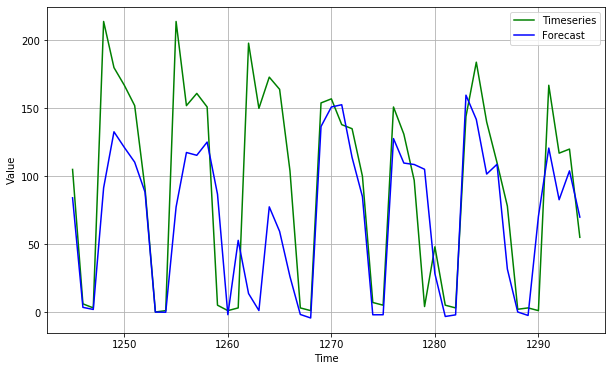

In [14]:
plt.figure(figsize=(10, 6))
start = 0
show_length = 100
plot_series(time_valid[-50:], x_valid[-50:],'g')
plot_series(time_valid[-50:], rnn_forecast[-50:],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [32]:
df = pd.DataFrame([date["Date"].iloc[-50:].values, rnn_forecast[-50:]]).T
df.columns = ["date", "value"]
df.to_csv("Plot_daily.csv")